In [ ]:
!pip install bdsf astroquery

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.4/999.4 kB 23.1 MB/s eta 0:00:00


In [ ]:
import os
from pathlib import Path
from typing import Optional, cast

import bdsf
import numpy as np
import pandas as pd
import torch
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astroquery.skyview import SkyView
from astroquery.vizier import Vizier
from PIL import Image

In [ ]:
def catalog_quest(name: str, service: str = "Vizier") -> pd.DataFrame:
    """
    Fetch a catalog from a given astronomical service e.g. VizieR, Simbad.

    :param name: The name of the catalog to be fetched.
    :type name: str

    :param service: The name of the astronomical service to be used.
    :type service: str

    :return: A pandas DataFrame containing the fetched catalog.
    :rtype: pd.DataFrame

    :raises _UnsupportedServiceError: If an unsupported service is provided.
    """
    if service == "Vizier":
        Vizier.ROW_LIMIT = -1
        catalog = Vizier.get_catalogs(name)
        return cast(pd.DataFrame, catalog[0].to_pandas())
    else:
        raise _UnsupportedServiceError()


class _UnsupportedServiceError(Exception):
    """
    An exception to be raised when an unsupported service is provided.
    """

    def __init__(self) -> None:
        super().__init__("Unsupported service provided. Only 'Vizier' is supported.")


def celestial_capture(survey: str, ra: float, dec: float, filename: str) -> None:
    """
    Capture a celestial image using the SkyView service.

    :param survey: The name of the survey to be used e.g. 'VLA FIRST (1.4 GHz)'.
    :type survey: str

    :param ra: The right ascension of the celestial object.
    :type ra: Skycoord

    :param dec: The declination of the celestial object.
    :type dec: Skycoord

    :param filename: The name of the file to save the image.
    :type filename: str
    """
    image = SkyView.get_images(position=f"{ra}, {dec}", survey=survey, coordinates="J2000", pixels=(150, 150))[0]

    comment = str(image[0].header["COMMENT"])
    comment = comment.replace("\n", " ")
    comment = comment.replace("\t", " ")

    image[0].header.remove("comment", comment, True)
    image[0].header.add_comment(comment)

    folder_path = Path(filename).parent
    Path(folder_path).mkdir(parents=True, exist_ok=True)
    image.writeto(filename, overwrite=True)


def celestial_tag(entry: pd.Series) -> str:
    """
    Generate a name tag for a celestial object based on its coordinates.

    :param entry: A pandas Series entry of the catalog.
    :type entry: pd.Series

    :return: A string containing the name tag.
    :rtype: str

    :raises _NoValidCelestialCoordinatesError: If no valid celestial coordinates are found in the entry.
    """

    def format_dec(dec: str) -> str:
        sign = "+" if float(dec.replace(" ", "")) > 0 else ""
        return f"{sign}{dec}"

    if {"RAJ2000", "DEJ2000"}.issubset(entry.index):
        ra, dec = entry["RAJ2000"], entry["DEJ2000"]
    elif {"RA", "DEC"}.issubset(entry.index):
        ra, dec = entry["RA"], entry["DEC"]
    elif "filename" in entry.index:
        return f"{entry['filename']}"
    elif "FCG" in entry.index:
        return f"{entry['FCG']}"
    else:
        raise _NoValidCelestialCoordinatesError()

    return f"{ra}{format_dec(dec)}"


class _NoValidCelestialCoordinatesError(Exception):
    """
    An exception to be raised when no valid celestial coordinates are found in the entry.
    """

    def __init__(self) -> None:
        super().__init__("No valid celestial coordinates found in the entry to generate a tag.")


class _FileNotFoundError(Exception):
    """
    An exception to be raised when a file is not found.
    """

    def __init__(self, message: str = "File not found.") -> None:
        super().__init__(message)


def fits_to_png(fits_file: str, img_size: Optional[tuple[int, int]] = None) -> Image.Image:
    """
    Convert a FITS file to a PNG image.

    :param fits_file: The path to the FITS file.
    :type fits_file: str

    :param img_size: The size of the output image.
    :type img_size: Optional[tuple[int, int]]

    :return: A PIL Image object containing the PNG image.
    :rtype: Image.Image

    :raises _FileNotFoundError: If the FITS file is not found.
    """
    try:
        image = fits.getdata(fits_file)
        header = fits.getheader(fits_file)
    except FileNotFoundError as err:
        raise _FileNotFoundError(fits_file) from err

    if img_size is not None:
        width, height = img_size
    else:
        width, height = header["NAXIS1"], header["NAXIS2"]

    image = np.reshape(image, (height, width))
    image[np.isnan(image)] = np.nanmin(image)

    image = (image - np.nanmin(image)) / (np.nanmax(image) - np.nanmin(image)) * 255
    image = image.astype(np.uint8)
    image = Image.fromarray(image, mode="L")

    return cast(Image.Image, image)


def fits_to_png_bulk(fits_dir: str, png_dir: str, img_size: Optional[tuple[int, int]] = None) -> None:
    """
    Convert a directory of FITS files to PNG images.

    :param fits_dir: The path to the directory containing the FITS files.
    :type fits_dir: str

    :param png_dir: The path to the directory to save the PNG images.
    :type png_dir: str

    :param img_size: The size of the output image.
    :type img_size: Optional[tuple[int, int]]
    """
    fits_files = Path(fits_dir).rglob("*.fits")
    for fits_file in fits_files:
        image = fits_to_png(str(fits_file), img_size)

        png_file = os.path.join(png_dir, fits_file.stem)
        Path(png_file).parent.mkdir(parents=True, exist_ok=True)

        if image is not None:
            image.save(png_file)


def mask_image(image: Image.Image, mask: Image.Image) -> Image.Image:
    """
    Mask an image with a given mask image.

    :param image: The image to be masked.
    :type image: Image.Image

    :param mask: The mask image.
    :type mask: Image.Image

    :return: A PIL Image object containing the masked image.
    :rtype: Image.Image

    :raises _ImageMaskDimensionError: If the dimensions of the image and mask do not match.
    """
    image_array = np.array(image)
    mask_array = np.array(mask)

    if image_array.shape != mask_array.shape:
        raise _ImageMaskDimensionError()

    masked_array = np.where(mask_array == 0, 0, image_array)
    masked_image = Image.fromarray(masked_array, mode="L")

    return cast(Image.Image, masked_image)


class _ImageMaskDimensionError(Exception):
    """
    An exception to be raised when the dimensions of the image and mask do not match.
    """

    def __init__(self) -> None:
        super().__init__("Image and mask must have the same dimensions.")


class _ImageMaskCountMismatchError(Exception):
    """
    An exception to be raised when the number of images and masks do not match.
    """

    def __init__(self, message: str = "Number of images and masks must match and be non-zero.") -> None:
        super().__init__(message)


def mask_image_bulk(image_dir: str, mask_dir: str, masked_dir: str) -> None:
    """
    Mask a directory of images with a directory of mask images.

    :param image_dir: The path to the directory containing the images.
    :type image_dir: str

    :param mask_dir: The path to the directory containing the mask images.
    :type mask_dir: str

    :param masked_dir: The path to the directory to save the masked images.
    :type masked_dir: str

    :raises _FileNotFoundError: If no images or masks are found in the directories.
    :raises _ImageMaskCountMismatchError: If the number of images and masks do not match.
    """
    image_paths = sorted(Path(image_dir).glob("*.png"))
    mask_paths = sorted(Path(mask_dir).glob("*.png"))

    if len(image_paths) == 0 or len(mask_paths) == 0:
        raise _FileNotFoundError()

    if len(image_paths) != len(mask_paths):
        raise _ImageMaskCountMismatchError() from None

    os.makedirs(masked_dir, exist_ok=True)

    for image_path in image_paths:
        mask_path = Path(mask_dir) / image_path.name

        if not mask_path.exists():
            print(f"Skipping {image_path.name} due to missing mask.")
            continue

        image = Image.open(image_path)
        mask = Image.open(mask_path)

        if image.size != mask.size:
            print(f"Skipping {image_path.name} due to mismatched dimensions.")
            continue
        else:
            masked_image = mask_image(image, mask)

        masked_image.save(Path(masked_dir) / image_path.name)


class _ColumnNotFoundError(Exception):
    """
    An exception to be raised when a specified column is not found in the catalog.
    """

    def __init__(self, column: str) -> None:
        super().__init__(f"Column {column} not found in the catalog.")


def _get_class_labels(catalog: pd.Series, classes: dict, cls_col: str) -> str:
    """
    Get the class labels for the celestial objects in the catalog.

    :param catalog: A pandas Series representing a row in the catalog of celestial objects.
    :type catalog: pd.Series

    :param classes: A dictionary containing the classes of the celestial objects.
    :type classes: dict

    :param cls_col: The name of the column containing the class labels.
    :type cls_col: str

    :return: Class labels for the celestial objects in the catalog.
    :rtype: str

    :raises _ColumnNotFoundError: If the specified column is not found in the catalog.
    """
    if cls_col not in catalog.index:
        raise _ColumnNotFoundError(cls_col)

    value = catalog[cls_col]
    for key, label in classes.items():
        if key in value:
            return str(label)

    return ""


def celestial_capture_bulk(
    catalog: pd.DataFrame, survey: str, img_dir: str, classes: Optional[dict] = None, cls_col: Optional[str] = None
) -> None:
    """
    Capture celestial images for a catalog of celestial objects.

    :param catalog: A pandas DataFrame containing the catalog of celestial objects.
    :type catalog: pd.DataFrame

    :param survey: The name of the survey to be used e.g. 'VLA FIRST (1.4 GHz)'.
    :type survey: str

    :param img_dir: The path to the directory to save the images.
    :type img_dir: str

    :param classes: A dictionary containing the classes of the celestial objects.
    :type classes: dict

    :param cls_col: The name of the column containing the class labels.

    :raises _InvalidCoordinatesError: If coordinates are invalid.
    """
    failed = pd.DataFrame(columns=catalog.columns)
    for _, entry in catalog.iterrows():
        try:
            tag = celestial_tag(entry)
            coordinate = SkyCoord(tag, unit=(u.hourangle, u.deg))

            right_ascension = coordinate.ra.deg
            declination = coordinate.dec.deg

            label = _get_class_labels(entry, classes, cls_col) if classes is not None and cls_col is not None else ""

            if "filename" in catalog.columns:
                filename = f'{img_dir}/{label}_{entry["filename"]}.fits'
            else:
                filename = f"{img_dir}/{label}_{tag}.fits"

            celestial_capture(survey, right_ascension, declination, filename)
        except Exception as err:
            series = entry.to_frame().T
            failed = pd.concat([failed, series], ignore_index=True)
            print(f"Failed to capture image. {err}")


def dataframe_to_html(catalog: pd.DataFrame, save_dir: str) -> None:
    """
    Save the catalog as an HTML file.

    :param catalog: Catalog of the astronomical objects
    :type catalog: pd.DataFrame
    :param save_dir: Path to the directory to save the HTML file
    :type save_dir: str
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    catalog.to_html(os.path.join(save_dir, "catalog.html"))


def compute_mean_std(dataloader: torch.utils.data.DataLoader) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Compute the mean and standard deviation of the dataset.

    :param dataloader: The dataloader for the dataset.
    :type dataloader: torch.utils.data.DataLoader

    :return: The mean and standard deviation of the dataset.
    :rtype: tuple[torch.Tensor, torch.Tensor]
    """
    data = torch.tensor([])
    for batch in dataloader:
        data = torch.cat((data, batch[0]), 0)

    mean = torch.mean(data, dim=(0, 2, 3))
    std = torch.std(data, dim=(0, 2, 3))

    return mean, std


def remove_artifacts(folder: str, extension: list[str]) -> None:
    """
    Remove files with the given extensions from a folder.

    :param folder: Path to the folder to clear
    :type folder: str
    :param extension: List of file with the given extensions to keep
    :type extension: list
    """
    for file in os.listdir(folder):
        if not file.endswith(tuple(extension)):
            os.remove(os.path.join(folder, file))

    print(f"Artifacts removed from {folder} with extensions {', '.join(extension)}")


def generate_mask(
    image_path: str,
    mask_dir: str,
    freq: float,
    beam: tuple[float, float, float],
    dilation: int,
    threshold_pixel: float = 5.0,
    threshold_island: float = 3.0,
) -> None:
    """
    Detect sources in the image and generate a mask.

    :param image_path: Path to the image file
    :type image_path: str

    :param mask_dir: Path to the directory to save the mask
    :type mask_dir: str

    :param freq: Frequency of the image in MHz
    :type freq: float

    :param beam: Beam size of the image in arcsec
    :type beam: tuple

    :param dilation: Dilation factor for the mask
    :type dilation: int

    :param threshold_pixel: Threshold for island peak in number of sigma above the mean
    :type threshold_pixel: float

    :param threshold_island: Threshold for island detection in number of sigma above the mean
    :type threshold_island: float
    """
    try:
        image = bdsf.process_image(
            image_path,
            beam=beam,
            thresh_isl=threshold_island,
            thresh_pix=threshold_pixel,
            frequency=freq,
        )

        mask_file = Path(mask_dir) / Path(image_path).name
        Path(mask_file).parent.mkdir(parents=True, exist_ok=True)

        image.export_image(
            img_type="island_mask",
            outfile=mask_file,
            clobber=True,
            mask_dilation=dilation,
        )

    except Exception:
        print("Failed to generate mask.")
        return None


def generate_mask_bulk(
    catalog: pd.DataFrame, img_dir: str, mask_dir: str, freq: float, beam: tuple[float, float, float]
) -> None:
    """
    Generate masks for a catalog of celestial objects.

    :param catalog: A pandas DataFrame containing the catalog of celestial objects.
    :type catalog: pd.DataFrame

    :param img_dir: The path to the directory containing the images.
    :type img_dir: str

    :param mask_dir: The path to the directory to save the masks.
    :type mask_dir: str

    :param freq: Frequency of the image in MHz
    :type freq: float

    :param beam: Beam size of the image in arcsec
    :type beam: tuple
    """
    for _, entry in catalog.iterrows():
        try:
            filename = entry["filename"]
            image_path = os.path.join(img_dir, f"{filename}.fits")
            dilation = entry["dilation"]
            threshold_pixel = entry["background sigma"]
            threshold_island = entry["foreground sigma"]

            generate_mask(
                image_path,
                mask_dir,
                freq,
                beam,
                dilation,
                threshold_pixel,
                threshold_island,
            )

        except Exception as err:
            print(f"Failed to generate mask. {err}")
            return None


In [ ]:
import numpy as np
from astropy.io import fits
from PIL import Image
import os

def fits_to_png_224x224(fits_path, output_path):
    """
    Convert FITS file to PNG and resize to 224x224 pixels.

    Args:
        fits_path (str): Path to input FITS file
        output_path (str): Path to save output PNG file
    """
    try:
        # Read FITS file
        with fits.open(fits_path) as hdul:
            image_data = hdul[0].data

        # Replace NaN values with minimum non-NaN value
        image_data = np.nan_to_num(image_data, nan=np.nanmin(image_data))

        # Normalize to 0-255 range
        normalized = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))
        normalized = (normalized * 255).astype(np.uint8)

        # Create PIL Image
        img = Image.fromarray(normalized)

        # Resize to 224x224 using Lanczos resampling (high quality)
        img_resized = img.resize((224, 224), Image.Resampling.LANCZOS)

        # Save as PNG
        img_resized.save(output_path)
        print(f"Successfully converted and saved to {output_path}")

    except Exception as e:
        print(f"Error processing {fits_path}: {str(e)}")

# Example usage
input_fits = "/content/Fits_Data/J070314.5+634807.fits"  # Replace with your FITS file path
output_png = "/content/PNG_Data/output_image.png"  # Output file path

# Create output directory if it doesn't exist
os.makedirs(os.path.dirname(output_png), exist_ok=True)

fits_to_png_224x224(input_fits, output_png)

Successfully converted and saved to /content/PNG_Data/output_image.png


In [ ]:
import numpy as np
from astropy.io import fits
from PIL import Image
import os

def fits_to_png_224x224(fits_path, output_path):
    """
    Convert FITS file to PNG and resize to 224x224 pixels.

    Args:
        fits_path (str): Path to input FITS file
        output_path (str): Path to save output PNG file
    """
    try:
        # Read FITS file
        with fits.open(fits_path) as hdul:
            image_data = hdul[0].data

        # Replace NaN values with minimum non-NaN value
        image_data = np.nan_to_num(image_data, nan=np.nanmin(image_data))

        # Normalize to 0-255 range
        normalized = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))
        normalized = (normalized * 255).astype(np.uint8)

        # Create PIL Image
        img = Image.fromarray(normalized)

        # Resize to 224x224 using Lanczos resampling (high quality)
        img_resized = img.resize((224, 224))

        # Save as PNG
        img_resized.save(output_path)
        print(f"Successfully converted and saved to {output_path}")

    except Exception as e:
        print(f"Error processing {fits_path}: {str(e)}")

# Example usage
input_fits = "/content/Fits_Data/J070314.5+634807.fits"  # Replace with your FITS file path
output_png = "/content/PNG_Data/output_image.png"  # Output file path

# Create output directory if it doesn't exist
os.makedirs(os.path.dirname(output_png), exist_ok=True)

fits_to_png_224x224(input_fits, output_png)

Successfully converted and saved to /content/PNG_Data/output_image.png


In [ ]:
import numpy as np
from astropy.io import fits
from PIL import Image
import os

def fits_to_png_preserve_orientation(fits_path, output_path):
    """
    Convert FITS file to PNG, preserving original dimensions and correcting orientation.

    Args:
        fits_path (str): Path to input FITS file.
        output_path (str): Path to save output PNG file.
    """
    try:
        # Read FITS file
        with fits.open(fits_path) as hdul:
            # Access the primary data unit (usually index 0)
            # Make sure this index is correct for your FITS file structure
            if not hdul or not hasattr(hdul[0], 'data') or hdul[0].data is None:
                print(f"Error: No image data found in HDU 0 of {fits_path}")
                return
            image_data = hdul[0].data

            # Check if data is 2D (image)
            if image_data.ndim != 2:
                print(f"Error: Data in HDU 0 of {fits_path} is not 2D (shape: {image_data.shape}). Skipping.")
                return

        # Handle potential NaN values *before* normalization
        # Replace NaN with the minimum finite value in the image
        min_finite_val = np.nanmin(image_data[np.isfinite(image_data)])
        image_data = np.nan_to_num(image_data, nan=min_finite_val)

        # --- Correction: Flip the image vertically ---
        # FITS often has origin at bottom-left, NumPy/PIL use top-left.
        # flipud flips the array along the Up/Down axis.
        image_data_flipped = np.flipud(image_data)

        # Normalize to 0-255 range for PNG display
        # Ensure max != min to avoid division by zero
        img_min = np.min(image_data_flipped)
        img_max = np.max(image_data_flipped)
        if img_max <= img_min:
             # Handle constant image case (or near constant)
             print(f"Warning: Image data in {fits_path} has near-zero range. Output might be blank.")
             normalized = np.zeros_like(image_data_flipped, dtype=np.uint8)
        else:
            normalized = (image_data_flipped - img_min) / (img_max - img_min)
            normalized = (normalized * 255).astype(np.uint8)

        # Create PIL Image from the flipped and normalized array
        img = Image.fromarray(normalized)

        # --- Removed Resizing ---
        # The image will retain its original dimensions from the FITS file.
        # img_resized = img.resize((224, 224), Image.Resampling.LANCZOS) # Removed

        # Save as PNG
        img.save(output_path) # Save the original size image
        print(f"Successfully converted and saved to {output_path} (Original Dimensions, Corrected Orientation)")

    except FileNotFoundError:
        print(f"Error: Input FITS file not found at {fits_path}")
    except IndexError:
         print(f"Error: Could not access HDU 0 in {fits_path}. Check FITS structure.")
    except Exception as e:
        print(f"Error processing {fits_path}: {str(e)}")

# --- Example Usage ---
# Replace with the actual path to YOUR FITS file
input_fits = "/content/Fits_Data/J070314.5+634807.fits"
# Choose a new name for the orientation-corrected output
output_png_corrected = "/content/PNG_Data/output_image_corrected.png"

# Create output directory if it doesn't exist
# Ensure the directory part of the path exists
output_dir = os.path.dirname(output_png_corrected)
if output_dir and not os.path.exists(output_dir):
    os.makedirs(output_dir)
elif not output_dir: # Handle case where output is in the current directory
     pass

# Run the conversion function
fits_to_png_preserve_orientation(input_fits, output_png_corrected)


Successfully converted and saved to /content/PNG_Data/output_image_corrected.png (Original Dimensions, Corrected Orientation)


In [ ]:
# Final Fits to PNG Single file conversion
import numpy as np
from astropy.io import fits
from PIL import Image
import os

def fits_to_png_resized_oriented(fits_path, output_path, size=(224, 224)):
    """
    Convert FITS file to PNG, correcting orientation and resizing.

    Args:
        fits_path (str): Path to input FITS file.
        output_path (str): Path to save output PNG file.
        size (tuple): Desired output size (width, height) in pixels.
                      Defaults to (224, 224).
    """
    try:
        # Read FITS file
        with fits.open(fits_path) as hdul:
            # Access the primary data unit (usually index 0)
            if not hdul or not hasattr(hdul[0], 'data') or hdul[0].data is None:
                print(f"Error: No image data found in HDU 0 of {fits_path}")
                return
            image_data = hdul[0].data

            # Check if data is 2D (image)
            if image_data.ndim != 2:
                print(f"Error: Data in HDU 0 of {fits_path} is not 2D (shape: {image_data.shape}). Skipping.")
                return

        # Handle potential NaN values *before* normalization
        # Replace NaN with the minimum finite value in the image
        if np.isnan(image_data).any(): # Check if NaNs exist before calculating nanmin
             finite_data = image_data[np.isfinite(image_data)]
             if finite_data.size > 0: # Ensure there are finite values
                 min_finite_val = np.min(finite_data)
                 image_data = np.nan_to_num(image_data, nan=min_finite_val)
             else: # Handle case where all values are NaN or infinite
                 print(f"Warning: Image data in {fits_path} contains only NaN/infinite values. Output might be blank.")
                 image_data = np.zeros_like(image_data) # Replace with zeros

        # --- Correction: Flip the image vertically ---
        # FITS often has origin at bottom-left, NumPy/PIL use top-left.
        image_data_flipped = np.flipud(image_data)

        # Normalize to 0-255 range for PNG display
        img_min = np.min(image_data_flipped)
        img_max = np.max(image_data_flipped)
        if img_max <= img_min:
             print(f"Warning: Image data in {fits_path} has near-zero range after processing. Output might be blank.")
             normalized = np.zeros_like(image_data_flipped, dtype=np.uint8)
        else:
            normalized = (image_data_flipped - img_min) / (img_max - img_min)
            normalized = (normalized * 255).astype(np.uint8)

        # Create PIL Image from the flipped and normalized array
        img = Image.fromarray(normalized)

        # --- Resize to the specified size using Lanczos resampling ---
        img_resized = img.resize(size, Image.Resampling.LANCZOS)

        # Save the resized image as PNG
        img_resized.save(output_path)
        print(f"Successfully converted, oriented, resized to {size}, and saved to {output_path}")

    except FileNotFoundError:
        print(f"Error: Input FITS file not found at {fits_path}")
    except IndexError:
         print(f"Error: Could not access HDU 0 in {fits_path}. Check FITS structure.")
    except Exception as e:
        print(f"Error processing {fits_path}: {str(e)}")

# --- Example Usage ---
# Replace with the actual path to YOUR FITS file
input_fits = "/content/Fits_Data/J070314.5+634807.fits"
# Choose a name for the resized and oriented output
output_png_resized = "/content/PNG_Data/output_image_resized_oriented_224.png"
output_size = (224, 224) # Define the desired output size

# Create output directory if it doesn't exist
output_dir = os.path.dirname(output_png_resized)
if output_dir and not os.path.exists(output_dir):
    os.makedirs(output_dir)
elif not output_dir:
     pass # Outputting to current directory

# Run the conversion function
fits_to_png_resized_oriented(input_fits, output_png_resized, size=output_size)


Successfully converted, oriented, resized to (224, 224), and saved to /content/PNG_Data/output_image_resized_oriented_224.png


In [ ]:
# Final Fits to PNG Conversion Pipeline. Here during resizing mask image remove Image.Resampling.LANCZOS
import numpy as np
from astropy.io import fits
from PIL import Image
import os
import glob # Import glob to find files

def fits_to_png_resized_oriented(fits_path, output_path, size=(224, 224)):
    """
    Convert a single FITS file to PNG, correcting orientation and resizing.

    Args:
        fits_path (str): Path to the input FITS file.
        output_path (str): Path to save the output PNG file.
        size (tuple): Desired output size (width, height) in pixels.
                      Defaults to (224, 224).
    """
    try:
        # Read FITS file
        with fits.open(fits_path) as hdul:
            # Find the first HDU with image data
            image_hdu = None
            for hdu in hdul:
                if isinstance(hdu, (fits.ImageHDU, fits.PrimaryHDU)) and hdu.data is not None and hdu.data.ndim >= 2:
                    # Select the first valid image HDU found
                    image_hdu = hdu
                    break

            if image_hdu is None:
                print(f"Error: No suitable image HDU found in {fits_path}. Skipping.")
                return

            image_data = image_hdu.data

            # Handle potential higher dimensions (e.g., data cubes) - take the first slice
            if image_data.ndim > 2:
                print(f"Warning: Data in {fits_path} has {image_data.ndim} dimensions. Using slice [0]. Shape: {image_data.shape}")
                image_data = image_data[0] # Adjust index if needed for your specific data cubes

            # Ensure data is 2D after potential slicing
            if image_data.ndim != 2:
                 print(f"Error: Data in {fits_path} is not 2D after processing. Shape: {image_data.shape}. Skipping.")
                 return


        # Handle potential NaN values *before* normalization
        if np.isnan(image_data).any():
             finite_data = image_data[np.isfinite(image_data)]
             if finite_data.size > 0:
                 min_finite_val = np.min(finite_data)
                 image_data = np.nan_to_num(image_data, nan=min_finite_val)
             else:
                 print(f"Warning: Image data in {fits_path} contains only NaN/infinite values. Output might be blank.")
                 image_data = np.zeros_like(image_data)

        # --- Correction: Flip the image vertically ---
        image_data_flipped = np.flipud(image_data)

        # Normalize to 0-255 range for PNG display
        img_min = np.min(image_data_flipped)
        img_max = np.max(image_data_flipped)
        if img_max <= img_min:
             # Handle constant image case
             # print(f"Info: Image data range is zero for {fits_path}. Output will be constant color.")
             # Assign a constant value (e.g., 0 for black) instead of trying to normalize
             normalized = np.zeros_like(image_data_flipped, dtype=np.uint8)
        else:
            normalized = (image_data_flipped - img_min) / (img_max - img_min)
            normalized = (normalized * 255).astype(np.uint8)

        # Create PIL Image from the flipped and normalized array
        img = Image.fromarray(normalized)

        # --- Resize to the specified size using Lanczos resampling ---
        img_resized = img.resize(size, Image.Resampling.LANCZOS)

        # Save the resized image as PNG
        img_resized.save(output_path)
        # print(f"Successfully converted: {os.path.basename(fits_path)} -> {os.path.basename(output_path)}") # Less verbose output for batch processing

    except FileNotFoundError:
        print(f"Error: Input FITS file not found at {fits_path}")
    except Exception as e:
        # Print filename along with the error for better debugging in batch mode
        print(f"Error processing {os.path.basename(fits_path)}: {str(e)}")


# --- Batch Processing Setup ---

# <<< IMPORTANT: SET YOUR DIRECTORIES HERE >>>
input_directory = "/content/Fits_Data"  # Replace with the path to the folder containing your FITS files
output_directory = "/content/PNG_Data" # Replace with the path where you want to save PNGs

output_size = (224, 224) # Define the desired output size

# --- Main Batch Processing Logic ---

if not os.path.isdir(input_directory):
    print(f"Error: Input directory not found: {input_directory}")
else:
    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)
    print(f"Input directory: {input_directory}")
    print(f"Output directory: {output_directory}")
    print(f"Output size: {output_size}")

    # Find all FITS files (case-insensitive matching for extensions .fit, .fits)
    # Using recursive=False to only search the top-level directory
    search_pattern_fits = os.path.join(input_directory, '*.fits')
    search_pattern_fit = os.path.join(input_directory, '*.fit')

    fits_files = glob.glob(search_pattern_fits) + glob.glob(search_pattern_fit)

    if not fits_files:
        print(f"No .fits or .fit files found in {input_directory}")
    else:
        print(f"Found {len(fits_files)} FITS file(s) to process...")
        processed_count = 0
        error_count = 0

        # Loop through each found FITS file
        for fits_path in fits_files:
            try:
                # Construct the output PNG filename
                base_filename = os.path.basename(fits_path)
                # Remove .fits or .fit extension and add .png
                png_filename = os.path.splitext(base_filename)[0] + '.png'
                output_path = os.path.join(output_directory, png_filename)

                # Call the conversion function for the current file
                fits_to_png_resized_oriented(fits_path, output_path, size=output_size)
                processed_count += 1
            except Exception as e:
                # Catch potential errors during filename processing or function call itself
                print(f"Failed to initiate processing for {os.path.basename(fits_path)}: {str(e)}")
                error_count += 1

        print(f"\nBatch processing complete.")
        print(f"Successfully processed: {processed_count}")
        print(f"Errors encountered: {error_count}")



Input directory: /content/Fits_Data
Output directory: /content/PNG_Data
Output size: (224, 224)
Found 2 FITS file(s) to process...

Batch processing complete.
Successfully processed: 2
Errors encountered: 0


In [ ]:
# Use this code if seperate data.py is given in the working directory
import os
from pathlib import Path

# Assuming data.py is in the same directory or accessible in your Python path
# If data.py is in a different directory, you might need to adjust the import path
try:
    from data import generate_mask
except ImportError:
    print("Error: Could not import generate_mask from data.py.")
    print("Please ensure data.py is in the same directory or accessible in your Python path.")
    exit()


def create_mask_for_fits(fits_filepath: str, output_mask_dir: str):
    """
    Generates a mask file for a given FITS file using the generate_mask function
    from data.py. The mask file will have the same base name as the FITS file.

    Args:
        fits_filepath (str): The full path to the input FITS file.
        output_mask_dir (str): The directory where the generated mask file
                                will be saved.
    """
    if not os.path.exists(fits_filepath):
        print(f"Error: FITS file not found at {fits_filepath}")
        return

    # Ensure the output directory exists
    Path(output_mask_dir).mkdir(parents=True, exist_ok=True)

    # --- Define parameters for generate_mask ---
    # These are example values. You should adjust them based on your FITS data
    # and the sources you want to mask.
    frequency_mhz = 1400.0  # Example: Frequency in MHz (e.g., for VLA FIRST)
    # Example: Beam size (major axis, minor axis, position angle in arcsec)
    # You can often find this in the FITS header.
    beam_arcsec = (5, 5, 0)
    dilation_factor = 0  # Dilation factor for the mask (expands the mask area)
    # Threshold for island detection in number of sigma above the mean
    threshold_island_sigma = 3.0
    # Threshold for island peak in number of sigma above the mean
    threshold_pixel_sigma = 5.0
    # -----------------------------------------

    print(f"Generating mask for {fits_filepath}...")

    generate_mask(
        image_path=fits_filepath,
        mask_dir=output_mask_dir,
        freq=frequency_mhz,
        beam=beam_arcsec,
        dilation=dilation_factor,
        threshold_island=threshold_island_sigma,
        threshold_pixel=threshold_pixel_sigma,
    )

    print(f"Mask generation process initiated for {fits_filepath}.")
    print(f"Mask file should be saved in {output_mask_dir} with the same base name.")


if __name__ == "__main__":
    # --- User Configuration ---
    # Replace with the actual path to your FITS file
    input_fits_file = "/content/Fits_Data/J070314.5+634807.fits"
    # Replace with the directory where you want to save the mask file
    output_directory_for_mask = "/content/mask_files/"
    # ------------------------

    create_mask_for_fits(input_fits_file, output_directory_for_mask)


INFO:PyBDSF.Process:Processing /content/Fits_Data/J070314.5+634807.fits
INFO:PyBDSF.Init:PyBDSF version 1.13.0.post2
INFO:PyBDSF.Init:Non-default input parameters:
    beam                 = (5.0, 5.0, 0.0)
    filename             = '/content/Fits_Data/J070314.5+634807.fits'
    frequency            = 1400.0
--> Opened '/content/Fits_Data/J070314.5+634807.fits'
USERINFO:PyBDSF.Readfile:--> Opened '/content/Fits_Data/J070314.5+634807.fits'
INFO:PyBDSF.Readfile:Original data shape of /content/Fits_Data/J070314.5+634807.fits: (300, 300)
INFO:PyBDSF.Readfile:Final data shape (npol, nchan, x, y): (1, 1, 300, 300)
Image size .............................. : (300, 300) pixels
USERINFO:PyBDSF.Readimage:Image size .............................. : (300, 300) pixels
Number of channels ...................... : 1
USERINFO:PyBDSF.Readimage:Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
USERINFO:PyBDSF.Readimage:Number of Stokes parameters ............. :

Generating mask for /content/Fits_Data/J070314.5+634807.fits...


Frequency of image ...................... : 0.001 MHz
USERINFO:PyBDSF.Collapse:Frequency of image ...................... : 0.001 MHz
Number of blank pixels .................. : 0 (0.0%)
USERINFO:PyBDSF.Collapse:Number of blank pixels .................. : 0 (0.0%)
INFO:PyBDSF.Preprocess:Raw mean (Stokes I) =  0.0203 mJy and raw rms =  0.6917 mJy 
INFO:PyBDSF.Preprocess:sigma clipped mean (Stokes I) =  0.0203 mJy and  sigma clipped rms =  0.6917 mJy 
Flux from sum of (non-blank) pixels ..... : 0.000 Jy
USERINFO:PyBDSF.Preprocess:Flux from sum of (non-blank) pixels ..... : 0.000 Jy
INFO:PyBDSF.Preprocess:Estimated bmpersrc_th =  555.56
INFO:PyBDSF.Preprocess:Parameter confused is False
--> Calculating background rms and mean images
USERINFO:PyBDSF.RMSimage:--> Calculating background rms and mean images
INFO:PyBDSF.RMSimage:Estimated size of brightest source (pixels) = 8493
INFO:PyBDSF.RMSimage:Maximum extent of largest 10-sigma island using clipped rms (pixels) = 15
Derived rms_box (box s

--> Wrote file PosixPath('/content/mask_files/J070314.5+634807.fits')
Mask generation process initiated for /content/Fits_Data/J070314.5+634807.fits.
Mask file should be saved in /content/mask_files/ with the same base name.


In [ ]:
import os
from pathlib import Path

# Assuming data.py is in the same directory or accessible in your Python path
# If data.py is in a different directory, you might need to adjust the import path


def create_mask_for_fits(fits_filepath: str, output_mask_dir: str):
    """
    Generates a mask file for a given FITS file using the generate_mask function
    from data.py. The mask file will have the same base name as the FITS file.

    Args:
        fits_filepath (str): The full path to the input FITS file.
        output_mask_dir (str): The directory where the generated mask file
                                will be saved.
    """
    if not os.path.exists(fits_filepath):
        print(f"Error: FITS file not found at {fits_filepath}")
        return

    # Ensure the output directory exists
    Path(output_mask_dir).mkdir(parents=True, exist_ok=True)

    # --- Define parameters for generate_mask ---
    # These are example values. You should adjust them based on your FITS data
    # and the sources you want to mask.
    frequency_mhz = 1400.0  # Example: Frequency in MHz (e.g., for VLA FIRST)
    # Example: Beam size (major axis, minor axis, position angle in arcsec)
    # You can often find this in the FITS header.
    beam_arcsec = (5, 5, 0)
    dilation_factor = 0  # Dilation factor for the mask (expands the mask area)
    # Threshold for island detection in number of sigma above the mean
    threshold_island_sigma = 3.0
    # Threshold for island peak in number of sigma above the mean
    threshold_pixel_sigma = 5.0
    # -----------------------------------------

    print(f"Generating mask for {fits_filepath}...")

    generate_mask(
        image_path=fits_filepath,
        mask_dir=output_mask_dir,
        freq=frequency_mhz,
        beam=beam_arcsec,
        dilation=dilation_factor,
        threshold_island=threshold_island_sigma,
        threshold_pixel=threshold_pixel_sigma,
    )

    print(f"Mask generation process initiated for {fits_filepath}.")
    print(f"Mask file should be saved in {output_mask_dir} with the same base name.")


if __name__ == "__main__":
    # --- User Configuration ---
    # Replace with the actual path to your FITS file
    input_fits_file = "/content/Fits_Data/J070314.5+634807.fits"
    # Replace with the directory where you want to save the mask file
    output_directory_for_mask = "/content/mask_files/"
    # ------------------------

    create_mask_for_fits(input_fits_file, output_directory_for_mask)


INFO:PyBDSF.Process:Processing /content/Fits_Data/J070314.5+634807.fits
INFO:PyBDSF.Init:PyBDSF version 1.13.0.post2
INFO:PyBDSF.Init:Non-default input parameters:
    beam                 = (5.0, 5.0, 0.0)
    filename             = '/content/Fits_Data/J070314.5+634807.fits'
    frequency            = 1400.0
--> Opened '/content/Fits_Data/J070314.5+634807.fits'
USERINFO:PyBDSF.Readfile:--> Opened '/content/Fits_Data/J070314.5+634807.fits'
INFO:PyBDSF.Readfile:Original data shape of /content/Fits_Data/J070314.5+634807.fits: (300, 300)
INFO:PyBDSF.Readfile:Final data shape (npol, nchan, x, y): (1, 1, 300, 300)
Image size .............................. : (300, 300) pixels
USERINFO:PyBDSF.Readimage:Image size .............................. : (300, 300) pixels
Number of channels ...................... : 1
USERINFO:PyBDSF.Readimage:Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
USERINFO:PyBDSF.Readimage:Number of Stokes parameters ............. :

Generating mask for /content/Fits_Data/J070314.5+634807.fits...


Frequency of image ...................... : 0.001 MHz
USERINFO:PyBDSF.Collapse:Frequency of image ...................... : 0.001 MHz
Number of blank pixels .................. : 0 (0.0%)
USERINFO:PyBDSF.Collapse:Number of blank pixels .................. : 0 (0.0%)
INFO:PyBDSF.Preprocess:Raw mean (Stokes I) =  0.0203 mJy and raw rms =  0.6917 mJy 
INFO:PyBDSF.Preprocess:sigma clipped mean (Stokes I) =  0.0203 mJy and  sigma clipped rms =  0.6917 mJy 
Flux from sum of (non-blank) pixels ..... : 0.000 Jy
USERINFO:PyBDSF.Preprocess:Flux from sum of (non-blank) pixels ..... : 0.000 Jy
INFO:PyBDSF.Preprocess:Estimated bmpersrc_th =  555.56
INFO:PyBDSF.Preprocess:Parameter confused is False
--> Calculating background rms and mean images
USERINFO:PyBDSF.RMSimage:--> Calculating background rms and mean images
INFO:PyBDSF.RMSimage:Estimated size of brightest source (pixels) = 8493
INFO:PyBDSF.RMSimage:Maximum extent of largest 10-sigma island using clipped rms (pixels) = 15
Derived rms_box (box s

Failed to generate mask.
Mask generation process initiated for /content/Fits_Data/J070314.5+634807.fits.
Mask file should be saved in /content/mask_files/ with the same base name.


In [ ]:
img = bdsf.process_image('/content/Fits_Data/J070314.5+634807.fits', beam=(5,5,0),frequency=1420)

INFO:PyBDSF.Process:Processing /content/Fits_Data/J070314.5+634807.fits
INFO:PyBDSF.Init:PyBDSF version 1.13.0.post2
INFO:PyBDSF.Init:Non-default input parameters:
    beam                 = (5.0, 5.0, 0.0)
    filename             = '/content/Fits_Data/J070314.5+634807.fits'
    frequency            = 1420.0
--> Opened '/content/Fits_Data/J070314.5+634807.fits'
USERINFO:PyBDSF.Readfile:--> Opened '/content/Fits_Data/J070314.5+634807.fits'
INFO:PyBDSF.Readfile:Original data shape of /content/Fits_Data/J070314.5+634807.fits: (300, 300)
INFO:PyBDSF.Readfile:Final data shape (npol, nchan, x, y): (1, 1, 300, 300)
Image size .............................. : (300, 300) pixels
USERINFO:PyBDSF.Readimage:Image size .............................. : (300, 300) pixels
Number of channels ...................... : 1
USERINFO:PyBDSF.Readimage:Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
USERINFO:PyBDSF.Readimage:Number of Stokes parameters ............. :

NOTE -- With the mouse pointer in plot window:
  Press "i" ........ : Get integrated flux densities and mean rms
                       values for the visible portion of the image
  Press "m" ........ : Change min and max scaling values
  Press "n" ........ : Show / hide island IDs
  Press "0" ........ : Reset scaling to default
  Click Gaussian ... : Print Gaussian and source IDs (zoom_rect mode, 
                       toggled with the "zoom" button and indicated in 
                       the lower right corner, must be off)
________________________________________________________________________


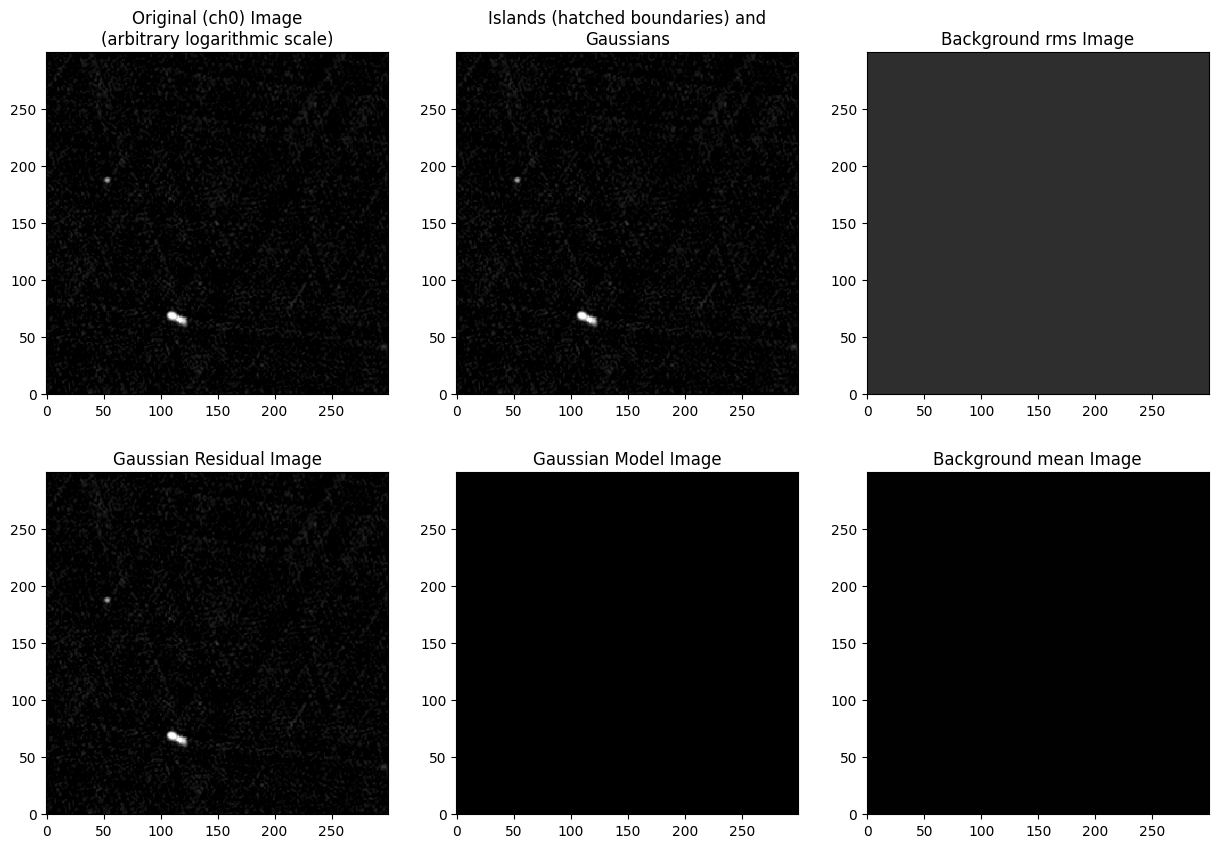

True

In [ ]:
img.show_fit()

In [ ]:
import os
from pathlib import Path
import sys
from astropy.io import fits # Import astropy.io.fits to potentially read header info

# Assuming data.py is in the same directory or accessible in your Python path
try:
    from data import generate_mask
except ImportError:
    print("Error: Could not import generate_mask from data.py.")
    print("Please ensure data.py is in the same directory or accessible in your Python path.")
    sys.exit(1)


def create_mask_for_fits(fits_filepath: str, output_mask_dir: str):
    """
    Generates a mask file for a given FITS file using the generate_mask function
    from data.py. The mask file will have the same base name as the FITS file.

    Args:
        fits_filepath (str): The full path to the input FITS file.
        output_mask_dir (str): The directory where the generated mask file
                                will be saved.
    """
    if not os.path.exists(fits_filepath):
        print(f"Error: FITS file not found at {fits_filepath}")
        return

    # Ensure the output directory exists
    try:
        Path(output_mask_dir).mkdir(parents=True, exist_ok=True)
    except OSError as e:
        print(f"Error creating output directory {output_mask_dir}: {e}")
        return

    # --- Define parameters for generate_mask ---
    # These parameters are CRITICAL for successful source detection.
    # You MUST adjust them based on the properties of your specific FITS file.

    # 1. Frequency: Frequency of the image in MHz.
    #    Look for keywords like 'FREQ', 'RESTFREQ', 'CRVAL3' in your FITS header.
    #    Example: VLA FIRST is around 1400 MHz.
    frequency_mhz = 1400.0

    # 2. Beam: Beam size (major axis, minor axis, position angle in arcsec).
    #    Look for keywords like 'BMAJ', 'BMIN', 'BPA' in your FITS header.
    #    If your beam is circular, BMAJ and BMIN will be equal, and BPA will be 0.
    #    Example: For a 5" circular beam.
    beam_arcsec = (5.0, 5.0, 0.0) # Use floats for beam values

    # 3. Dilation: Dilation factor for the mask.
    #    This expands the mask area around detected sources. A value of 0 means
    #    no dilation. Increase this if you want the mask to cover a larger area
    #    around the detected sources.
    dilation_factor = 2 # Example: Increase dilation to make the mask more visible

    # 4. Thresholds: These determine how bright a feature must be to be detected.
    #    'threshold_island' is the threshold for detecting an entire island of pixels.
    #    'threshold_pixel' is the threshold for individual pixels within an island.
    #    These are typically given in units of the background RMS noise (sigma).
    #    If no sources are detected, try lowering these values.
    #    Be cautious: lowering too much will detect noise as sources.
    threshold_island_sigma = 3.0 # Try lowering this if no islands are found
    threshold_pixel_sigma = 5.0  # Try lowering this if no pixels are found above background

    # --- Optional: Read parameters from FITS header ---
    # You can try to read beam and frequency directly from the FITS header
    # if they are present and correctly formatted.
    try:
        with fits.open(fits_filepath) as hdul:
            header = hdul[0].header # Assuming the primary HDU has the header

            # Attempt to read beam parameters
            if 'BMAJ' in header and 'BMIN' in header and 'BPA' in header:
                beam_arcsec = (header['BMAJ'] * 3600, header['BMIN'] * 3600, header['BPA']) # Convert deg to arcsec
                print(f"Using beam from FITS header: {beam_arcsec} arcsec")
            else:
                print("Beam parameters (BMAJ, BMIN, BPA) not found in FITS header. Using default/manual values.")

            # Attempt to read frequency
            if 'FREQ' in header:
                 frequency_mhz = header['FREQ'] / 1e6 # Assuming FREQ is in Hz, convert to MHz
                 print(f"Using frequency from FITS header: {frequency_mhz} MHz")
            elif 'RESTFREQ' in header:
                 frequency_mhz = header['RESTFREQ'] / 1e6 # Assuming RESTFREQ is in Hz, convert to MHz
                 print(f"Using frequency from FITS header: {frequency_mhz} MHz")
            else:
                print("Frequency (FREQ or RESTFREQ) not found in FITS header. Using default/manual value.")

    except Exception as e:
        print(f"Warning: Could not read FITS header for parameters: {e}")
        print("Using default/manual beam and frequency values.")
    # --- End Optional Header Reading ---


    print(f"Attempting to generate mask for {fits_filepath} with parameters:")
    print(f"  Frequency: {frequency_mhz} MHz")
    print(f"  Beam: {beam_arcsec} arcsec")
    print(f"  Dilation: {dilation_factor}")
    print(f"  Island Threshold: {threshold_island_sigma} sigma")
    print(f"  Pixel Threshold: {threshold_pixel_sigma} sigma")


    try:
        # Call the generate_mask function from data.py
        generate_mask(
            image_path=fits_filepath,
            mask_dir=output_mask_dir,
            freq=frequency_mhz,
            beam=beam_arcsec,
            dilation=dilation_factor,
            threshold_island=threshold_island_sigma,
            threshold_pixel=threshold_pixel_sigma,
        )
        print(f"Mask generation process for {fits_filepath} completed (or initiated by bdsf).")
        print(f"Mask file should be saved in {output_mask_dir} with the base name {Path(fits_filepath).stem}.fits") # bdsf saves as .fits

    except Exception as e:
        # Catch any exception that occurs during the mask generation
        print(f"\n")
        print(f"----------------------------------------------------")
        print(f"ERROR DURING MASK GENERATION:")
        print(f"An unexpected error occurred while processing {fits_filepath}:")
        print(f"Error Type: {type(e).__name__}")
        print(f"Error Message: {e}")
        print(f"----------------------------------------------------")
        print(f"\n")


if __name__ == "__main__":
    # --- User Configuration ---
    # Replace with the actual path to your FITS file
    input_fits_file = "/content/Fits_Data/J070314.5+634807.fits"
    # Replace with the directory where you want to save the mask file
    output_directory_for_mask = "/content/mask_files/"
    # ------------------------

    # --- Important ---
    # Before running, make sure:
    # 1. The 'bdsf' library is installed (`pip install bdsf`)
    # 2. The 'astropy' library is installed (`pip install astropy`)
    # 3. The 'numpy' library is installed (`pip install numpy`)
    # 4. The 'Pillow' library is installed (`pip install Pillow`)
    # 5. The 'data.py' file is in the same directory or accessible in your Python path.
    # 6. The paths for input_fits_file and output_directory_for_mask are correct.
    # 7. You have checked the FITS header of your input file to get accurate
    #    values for frequency and beam parameters, and adjusted the script
    #    accordingly if the automatic header reading doesn't work or if
    #    you need to override them.
    # 8. You may need to experiment with 'threshold_island_sigma' and
    #    'threshold_pixel_sigma' to find sources in your image.
    # --- ----------- ---

    create_mask_for_fits(input_fits_file, output_directory_for_mask)


INFO:PyBDSF.Process:Processing /content/Fits_Data/J070314.5+634807.fits
INFO:PyBDSF.Init:PyBDSF version 1.13.0.post2
INFO:PyBDSF.Init:Non-default input parameters:
    beam                 = (5.0, 5.0, 0.0)
    filename             = '/content/Fits_Data/J070314.5+634807.fits'
    frequency            = 1400.0
--> Opened '/content/Fits_Data/J070314.5+634807.fits'
USERINFO:PyBDSF.Readfile:--> Opened '/content/Fits_Data/J070314.5+634807.fits'
INFO:PyBDSF.Readfile:Original data shape of /content/Fits_Data/J070314.5+634807.fits: (300, 300)
INFO:PyBDSF.Readfile:Final data shape (npol, nchan, x, y): (1, 1, 300, 300)
Image size .............................. : (300, 300) pixels
USERINFO:PyBDSF.Readimage:Image size .............................. : (300, 300) pixels
Number of channels ...................... : 1
USERINFO:PyBDSF.Readimage:Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
USERINFO:PyBDSF.Readimage:Number of Stokes parameters ............. :

Beam parameters (BMAJ, BMIN, BPA) not found in FITS header. Using default/manual values.
Frequency (FREQ or RESTFREQ) not found in FITS header. Using default/manual value.
Attempting to generate mask for /content/Fits_Data/J070314.5+634807.fits with parameters:
  Frequency: 1400.0 MHz
  Beam: (5.0, 5.0, 0.0) arcsec
  Dilation: 2
  Island Threshold: 3.0 sigma
  Pixel Threshold: 5.0 sigma


Frequency of image ...................... : 0.001 MHz
USERINFO:PyBDSF.Collapse:Frequency of image ...................... : 0.001 MHz
Number of blank pixels .................. : 0 (0.0%)
USERINFO:PyBDSF.Collapse:Number of blank pixels .................. : 0 (0.0%)
INFO:PyBDSF.Preprocess:Raw mean (Stokes I) =  0.0203 mJy and raw rms =  0.6917 mJy 
INFO:PyBDSF.Preprocess:sigma clipped mean (Stokes I) =  0.0203 mJy and  sigma clipped rms =  0.6917 mJy 
Flux from sum of (non-blank) pixels ..... : 0.000 Jy
USERINFO:PyBDSF.Preprocess:Flux from sum of (non-blank) pixels ..... : 0.000 Jy
INFO:PyBDSF.Preprocess:Estimated bmpersrc_th =  555.56
INFO:PyBDSF.Preprocess:Parameter confused is False
--> Calculating background rms and mean images
USERINFO:PyBDSF.RMSimage:--> Calculating background rms and mean images
INFO:PyBDSF.RMSimage:Estimated size of brightest source (pixels) = 8493
INFO:PyBDSF.RMSimage:Maximum extent of largest 10-sigma island using clipped rms (pixels) = 15
Derived rms_box (box s

Failed to generate mask.
Mask generation process for /content/Fits_Data/J070314.5+634807.fits completed (or initiated by bdsf).
Mask file should be saved in /content/mask_files/ with the base name J070314.5+634807.fits


In [ ]:
# Mask Create Version 2

import os
from pathlib import Path
import sys
from astropy.io import fits # Import astropy.io.fits to potentially read header info

# Assuming data.py is in the same directory or accessible in your Python path
try:
    # --- IMPORTANT ---
    # Before running, please ensure you have modified the 'generate_mask' function
    # in your data.py file to print the details of any caught exception.
    # For example, change:
    # except Exception:
    #     print("Failed to generate mask.")
    #     return None
    # to:
    # except Exception as e:
    #     print(f"Failed to generate mask: {e}")
    #     import traceback
    #     traceback.print_exc() # This will print the full error traceback
    #     return None
    # This will help diagnose the specific error when dilation is increased.
    # --- ----------- ---
    from data import generate_mask
except ImportError:
    print("Error: Could not import generate_mask from data.py.")
    print("Please ensure data.py is in the same directory or accessible in your Python path.")
    sys.exit(1)


def create_mask_for_fits(fits_filepath: str, output_mask_dir: str):
    """
    Generates a mask file for a given FITS file using the generate_mask function
    from data.py. The mask file will have the same base name as the FITS file
    and a .fits extension.

    Args:
        fits_filepath (str): The full path to the input FITS file.
        output_mask_dir (str): The directory where the generated mask file
                                will be saved.
    """
    if not os.path.exists(fits_filepath):
        print(f"Error: FITS file not found at {fits_filepath}")
        return

    # Ensure the output directory exists
    try:
        Path(output_mask_dir).mkdir(parents=True, exist_ok=True)
    except OSError as e:
        print(f"Error creating output directory {output_mask_dir}: {e}")
        return

    # --- Define parameters for generate_mask ---
    # These parameters are CRITICAL for successful source detection.
    # You MUST adjust them based on the properties of your specific FITS file.

    # 1. Frequency: Frequency of the image in MHz.
    #    Look for keywords like 'FREQ', 'RESTFREQ', 'CRVAL3' in your FITS header.
    #    Example: VLA FIRST is around 1400 MHz.
    frequency_mhz = 1400.0

    # 2. Beam: Beam size (major axis, minor axis, position angle in arcsec).
    #    Look for keywords like 'BMAJ', 'BMIN', 'BPA' in your FITS header.
    #    If your beam is circular, BMAJ and BMIN will be equal, and BPA will be 0.
    #    Example: For a 5" circular beam.
    beam_arcsec = (5.0, 5.0, 0.0) # Use floats for beam values

    # 3. Dilation: Dilation factor for the mask.
    #    This expands the mask area around detected sources. A value of 0 means
    #    no dilation. Increase this if you want the mask to cover a larger area
    #    around the detected sources.
    #    If increasing this causes issues, it might be related to memory or
    #    limitations in the bdsf library for large dilation factors.
    dilation_factor = 0 # You can increase this, but be aware of potential issues


    # 4. Thresholds: These determine how bright a feature must be to be detected.
    #    'threshold_island' is the threshold for detecting an entire island of pixels.
    #    'threshold_pixel' is the threshold for individual pixels within an island.
    #    These are typically given in units of the background RMS noise (sigma).
    #    If no sources are detected, try lowering these values.
    #    Be cautious: lowering too much will detect noise as sources.
    threshold_island_sigma = 3.0
    threshold_pixel_sigma = 5.0

    # --- Optional: Read parameters from FITS header ---
    try:
        with fits.open(fits_filepath) as hdul:
            header = hdul[0].header # Assuming the primary HDU has the header

            # Attempt to read beam parameters
            if 'BMAJ' in header and 'BMIN' in header and 'BPA' in header:
                # Convert degrees to arcseconds (1 degree = 3600 arcseconds)
                beam_arcsec = (header['BMAJ'] * 3600, header['BMIN'] * 3600, header['BPA'])
                print(f"Using beam from FITS header: {beam_arcsec} arcsec")
            else:
                print("Beam parameters (BMAJ, BMIN, BPA) not found in FITS header. Using default/manual values.")

            # Attempt to read frequency
            if 'FREQ' in header:
                 # Assuming FREQ is in Hz, convert to MHz (1 MHz = 1e6 Hz)
                 frequency_mhz = header['FREQ'] / 1e6
                 print(f"Using frequency from FITS header: {frequency_mhz} MHz")
            elif 'RESTFREQ' in header:
                 # Assuming RESTFREQ is in Hz, convert to MHz
                 frequency_mhz = header['RESTFREQ'] / 1e6
                 print(f"Using frequency from FITS header: {frequency_mhz} MHz")
            else:
                print("Frequency (FREQ or RESTFREQ) not found in FITS header. Using default/manual value.")

    except Exception as e:
        print(f"Warning: Could not read FITS header for parameters: {e}")
        print("Using default/manual beam and frequency values.")
    # --- End Optional Header Reading ---


    print(f"Attempting to generate mask for {fits_filepath} with parameters:")
    print(f"  Frequency: {frequency_mhz} MHz")
    print(f"  Beam: {beam_arcsec} arcsec")
    print(f"  Dilation: {dilation_factor}")
    print(f"  Island Threshold: {threshold_island_sigma} sigma")
    print(f"  Pixel Threshold: {threshold_pixel_sigma} sigma")

    # Construct the expected output mask file path (bdsf exports as .fits)
    mask_filename = Path(fits_filepath).stem + '.fits'
    output_mask_filepath = os.path.join(output_mask_dir, mask_filename)

    try:
        # Call the generate_mask function from data.py
        generate_mask(
            image_path=fits_filepath,
            mask_dir=output_mask_dir,
            freq=frequency_mhz,
            beam=beam_arcsec,
            dilation=dilation_factor,
            threshold_island=threshold_island_sigma,
            threshold_pixel=threshold_pixel_sigma,
        )
        print(f"generate_mask function call completed for {fits_filepath}.")

        # --- Check if the output file was created ---
        if os.path.exists(output_mask_filepath):
            print(f"Successfully generated mask file: {output_mask_filepath}")
        else:
            print(f"Mask generation function finished, but output file was NOT found at {output_mask_filepath}.")
            print("This might indicate an internal error in generate_mask or bdsf that was caught and suppressed.")
            print("Check the console output for any error messages printed by the modified generate_mask function.")


    except Exception as e:
        # This outer catch block is a fallback, the inner one in generate_mask
        # should ideally catch and print the specific bdsf error.
        print(f"\n")
        print(f"----------------------------------------------------")
        print(f"AN UNEXPECTED ERROR OCCURRED OUTSIDE generate_mask:")
        print(f"Error Type: {type(e).__name__}")
        print(f"Error Message: {e}")
        print(f"----------------------------------------------------")
        print(f"\n")


if __name__ == "__main__":
    # --- User Configuration ---
    # Replace with the actual path to your FITS file
    input_fits_file = "/content/Fits_Data/J070314.5+634807.fits"
    # Replace with the directory where you want to save the mask file
    output_directory_for_mask = "/content/mask_files/"
    # ------------------------

    # --- Important ---
    # Before running, make sure:
    # 1. You have modified the 'generate_mask' function in your data.py
    #    to print detailed exceptions (as described in the comments above).
    # 2. The 'bdsf' library is installed (`pip install bdsf`)
    # 3. The 'astropy' library is installed (`pip install astropy`)
    # 4. The 'numpy' library is installed (`pip install numpy`)
    # 5. The 'Pillow' library is installed (`pip install Pillow`)
    # 6. The 'data.py' file is in the same directory or accessible in your Python path.
    # 7. The paths for input_fits_file and output_directory_for_mask are correct.
    # 8. You have checked the FITS header of your input file to get accurate
    #    values for frequency and beam parameters, and adjusted the script
    #    accordingly if the automatic header reading doesn't work or if
    #    you need to override them.
    # 9. You may need to experiment with 'threshold_island_sigma' and
    #    'threshold_pixel_sigma' to find sources in your image.
    # --- ----------- ---

    create_mask_for_fits(input_fits_file, output_directory_for_mask)


INFO:PyBDSF.Process:Processing /content/Fits_Data/J070314.5+634807.fits
INFO:PyBDSF.Init:PyBDSF version 1.13.0.post2
INFO:PyBDSF.Init:Non-default input parameters:
    beam                 = (5.0, 5.0, 0.0)
    filename             = '/content/Fits_Data/J070314.5+634807.fits'
    frequency            = 1400.0


Beam parameters (BMAJ, BMIN, BPA) not found in FITS header. Using default/manual values.
Frequency (FREQ or RESTFREQ) not found in FITS header. Using default/manual value.
Attempting to generate mask for /content/Fits_Data/J070314.5+634807.fits with parameters:
  Frequency: 1400.0 MHz
  Beam: (5.0, 5.0, 0.0) arcsec
  Dilation: 0
  Island Threshold: 3.0 sigma
  Pixel Threshold: 5.0 sigma


--> Opened '/content/Fits_Data/J070314.5+634807.fits'
USERINFO:PyBDSF.Readfile:--> Opened '/content/Fits_Data/J070314.5+634807.fits'
INFO:PyBDSF.Readfile:Original data shape of /content/Fits_Data/J070314.5+634807.fits: (300, 300)
INFO:PyBDSF.Readfile:Final data shape (npol, nchan, x, y): (1, 1, 300, 300)
Image size .............................. : (300, 300) pixels
USERINFO:PyBDSF.Readimage:Image size .............................. : (300, 300) pixels
Number of channels ...................... : 1
USERINFO:PyBDSF.Readimage:Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
USERINFO:PyBDSF.Readimage:Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (5.00000e+00, 5.00000e+00, 0.0) degrees
USERINFO:PyBDSF.InitBeam:Beam shape (major, minor, pos angle) .... : (5.00000e+00, 5.00000e+00, 0.0) degrees
INFO:PyBDSF.InitFreq:Using user-specified frequency.
INFO:PyBDSF.Readimage:Equinox of image is 2000.000000.
Frequen

--> Wrote file PosixPath('/content/mask_files/J070314.5+634807.fits')
generate_mask function call completed for /content/Fits_Data/J070314.5+634807.fits.
Successfully generated mask file: /content/mask_files/J070314.5+634807.fits


In [ ]:
# Final Mask Fits File to PNG File Conversion Pipeline
import numpy as np
from astropy.io import fits
from PIL import Image
import os
import glob # Import glob to find files

def fits_to_png_resized_oriented(fits_path, output_path, size=(224, 224)):
    """
    Convert a single FITS file to PNG, correcting orientation and resizing.
    Handles 2D, 3D, and specific 4D FITS data cubes.

    Args:
        fits_path (str): Path to the input FITS file.
        output_path (str): Path to save the output PNG file.
        size (tuple): Desired output size (width, height) in pixels.
                      Defaults to (224, 224).
    """
    try:
        # Read FITS file
        with fits.open(fits_path) as hdul:
            # Find the first HDU with image data
            image_hdu = None
            for hdu in hdul:
                # Check if it's an ImageHDU or PrimaryHDU, has data, and is at least 2D
                if isinstance(hdu, (fits.ImageHDU, fits.PrimaryHDU)) and hdu.data is not None and hdu.data.ndim >= 2:
                    image_hdu = hdu
                    break # Found a suitable HDU, exit loop

            if image_hdu is None:
                print(f"Error: No suitable image HDU with 2D data found in {fits_path}. Skipping.")
                return

            image_data = image_hdu.data

            # --- Handle potential higher dimensions (e.g., data cubes) ---
            if image_data.ndim > 2:
                print(f"Warning: Data in {fits_path} has {image_data.ndim} dimensions. Original Shape: {image_data.shape}")
                # Attempt to reduce dimensions to 2D.
                # This logic might need adjustment based on the specific structure
                # of your multi-dimensional FITS files.

                if image_data.ndim == 3:
                    # For 3D data (e.g., (n, y, x)), take the first slice along the first axis
                    print(f"  Attempting to slice 3D data: using slice [0].")
                    image_data = image_data[0]
                elif image_data.ndim == 4:
                    # For 4D data (e.g., (n1, n2, y, x)), take the first slice along the first two axes
                    # This is based on the error message shape (1, 1, 300, 300)
                    print(f"  Attempting to slice 4D data: using slice [0, 0].")
                    try:
                         image_data = image_data[0, 0]
                    except IndexError:
                         print(f"  Error slicing 4D data with [0, 0]. Shape is {image_data.shape}. Skipping.")
                         return
                else:
                    # For other higher dimensions, print a warning and skip
                    print(f"  Error: Cannot handle {image_data.ndim} dimensions automatically. Skipping.")
                    return


            # Ensure data is 2D after potential slicing
            if image_data.ndim != 2:
                 print(f"Error: Data in {fits_path} is not 2D after processing. Final Shape: {image_data.shape}. Skipping.")
                 return


            # Handle potential NaN values *before* normalization
            if np.isnan(image_data).any() or np.isinf(image_data).any():
                 finite_data = image_data[np.isfinite(image_data)]
                 if finite_data.size > 0:
                     # Fill NaN/inf with the minimum finite value found in the data
                     min_finite_val = np.min(finite_data)
                     image_data = np.nan_to_num(image_data, nan=min_finite_val, posinf=min_finite_val, neginf=min_finite_val)
                     # print(f"Info: Handled NaN/Inf values in {os.path.basename(fits_path)} by filling with min finite value.")
                 else:
                     # If all values are NaN/inf, fill with 0 or a default value
                     print(f"Warning: Image data in {fits_path} contains only NaN/infinite values. Filling with 0.")
                     image_data = np.zeros_like(image_data)


            # --- Correction: Flip the image vertically ---
            # FITS data often has the first row at the bottom, while image formats
            # like PNG have the first row at the top. Flip to correct orientation.
            image_data_flipped = np.flipud(image_data)

            # Normalize to 0-255 range for PNG display
            img_min = np.min(image_data_flipped)
            img_max = np.max(image_data_flipped)
            if img_max <= img_min:
                 # Handle constant image case - set to black
                 # print(f"Info: Image data range is zero for {fits_path}. Output will be constant color.")
                 normalized = np.zeros_like(image_data_flipped, dtype=np.uint8)
            else:
                normalized = (image_data_flipped - img_min) / (img_max - img_min)
                normalized = (normalized * 255).astype(np.uint8)

            # Create PIL Image from the flipped and normalized array
            img = Image.fromarray(normalized, mode="L") # Use mode="L" for grayscale

            # --- Resize to the specified size using Lanczos resampling ---
            # Using Lanczos as in your original code
            img_resized = img.resize(size, Image.Resampling.LANCZOS)

            # Save the resized image as PNG
            img_resized.save(output_path)
            # print(f"Successfully converted: {os.path.basename(fits_path)} -> {os.path.basename(output_path)}") # Less verbose output for batch processing

    except FileNotFoundError:
        print(f"Error: Input FITS file not found at {fits_path}")
    except Exception as e:
        # Print filename along with the error for better debugging in batch mode
        print(f"Error processing {os.path.basename(fits_path)}: {str(e)}")


# --- Batch Processing Setup ---

# <<< IMPORTANT: SET YOUR DIRECTORIES HERE >>>
input_directory = "/content/mask_files" # Replace with the path to the folder containing your FITS files
output_directory = "/content/PNG_Mask" # Replace with the path where you want to save PNGs

output_size = (224, 224) # Define the desired output size

# --- Main Batch Processing Logic ---

if not os.path.isdir(input_directory):
    print(f"Error: Input directory not found: {input_directory}")
else:
    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)
    print(f"Input directory: {input_directory}")
    print(f"Output directory: {output_directory}")
    print(f"Output size: {output_size}")

    # Find all FITS files (case-insensitive matching for extensions .fit, .fits)
    # Using recursive=False to only search the top-level directory
    search_pattern_fits = os.path.join(input_directory, '*.fits')
    search_pattern_fit = os.path.join(input_directory, '*.fit')

    fits_files = glob.glob(search_pattern_fits) + glob.glob(search_pattern_fit)

    if not fits_files:
        print(f"No .fits or .fit files found in {input_directory}")
    else:
        print(f"Found {len(fits_files)} FITS file(s) to process...")
        processed_count = 0
        error_count = 0

        # Loop through each found FITS file
        for fits_path in fits_files:
            try:
                # Construct the output PNG filename
                base_filename = os.path.basename(fits_path)
                # Remove .fits or .fit extension and add .png
                png_filename = os.path.splitext(base_filename)[0] + '.png'
                output_path = os.path.join(output_directory, png_filename)

                # Call the conversion function for the current file
                fits_to_png_resized_oriented(fits_path, output_path, size=output_size)
                processed_count += 1
            except Exception as e:
                # Catch potential errors during filename processing or function call itself
                print(f"Failed to initiate processing for {os.path.basename(fits_path)}: {str(e)}")
                error_count += 1

        print(f"\nBatch processing complete.")
        print(f"Successfully processed: {processed_count}")
        print(f"Errors encountered: {error_count}")



Input directory: /content/mask_files
Output directory: /content/PNG_Mask
Output size: (224, 224)
Found 1 FITS file(s) to process...
  Attempting to slice 4D data: using slice [0, 0].

Batch processing complete.
Successfully processed: 1
Errors encountered: 0


In [ ]:
image_dir= "/content/PNG_Data"
mask_dir= "/content/PNG_Mask"
masked_dir = "/content/masked_dir"

mask_image_bulk(image_dir=image_dir, mask_dir=mask_dir, masked_dir=masked_dir)

In [ ]:
fits_dir = "/content/Fits_Data"
png_dir = "/content/PNG_Data"
img_size = (224, 224)
fits_to_png_bulk(fits_dir, png_dir, img_size)

ValueError: cannot reshape array of size 90000 into shape (224,224)